# Telco Churn

A classification project

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats


import wrangle as w
import explore as e
#import modeling as m

## Acquire

* Add information about how, where and when you acquired your data
* How/where did you get your data?
* When did you get your data?
* What is the size of your data? (columns and rows)
* What does each observation represent?
* What does each column represent?

In [2]:
#import unclean data from Codeup mySQL server
telco_unclean = w.get_telco_data()

### An initial look at the data

In [3]:
telco_unclean.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [4]:
telco_unclean.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

## Prepare

* Remove duplicate columns (payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id', )
* Drop customers whose total_charges are spaces; these customers are new customers (tenure=0 and churn=No)
* Encode churn as 'churn_encoded' {'Yes': 1, 'No': 0}, then drop 'churn' column
----
* List steps taken to clean your data here
* In particular call out how you handle null values and outliers in detail
* You must do this even if you do not do anything or do not encounter any
* Any time there is potential to make changes to the data you must be upfront about the changes you make or do not make

In [5]:
#clean the data to prep for exploration
telco = w.clean_telco(telco_unclean)

#split the data
train, validate, test = w.train_validate_test_split(telco, "churn_encoded")

In [6]:
telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,churn_encoded
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.30,One year,DSL,Mailed check,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.40,Month-to-month,DSL,Mailed check,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Month-to-month,Fiber optic,Electronic check,1
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Month-to-month,Fiber optic,Electronic check,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.40,Month-to-month,Fiber optic,Mailed check,1


In [7]:
telco.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
churn_encoded,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

**The following empty code block** is here to represent the countless questions, visualizations, and statistical tests 
that did not make your final report. Data scientist often create a myriad of questions, visualizations 
and statistical tests that do not make it into the final notebook. This is okay and expected. Remember 
that shotgun approaches to your data such as using pair plots to look at the relationships of each feature 
are a great way to explore your data, but they have no place in your final report. 
**Your final report is about showing and supporting your findings, not showing the work you did to get there!**

In [8]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7032 non-null   object 
 1   senior_citizen         7032 non-null   int64  
 2   partner                7032 non-null   object 
 3   dependents             7032 non-null   object 
 4   tenure                 7032 non-null   int64  
 5   phone_service          7032 non-null   object 
 6   multiple_lines         7032 non-null   object 
 7   online_security        7032 non-null   object 
 8   online_backup          7032 non-null   object 
 9   device_protection      7032 non-null   object 
 10  tech_support           7032 non-null   object 
 11  streaming_tv           7032 non-null   object 
 12  streaming_movies       7032 non-null   object 
 13  paperless_billing      7032 non-null   object 
 14  monthly_charges        7032 non-null   float64
 15  tota

## You may use this as a template for how to ask and answer each question:

## Does a customer's tenure affect churn? :

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

In [8]:
train_churn = train[train.churn_encoded == 1]
train_no_churn = train[train.churn_encoded == 0]

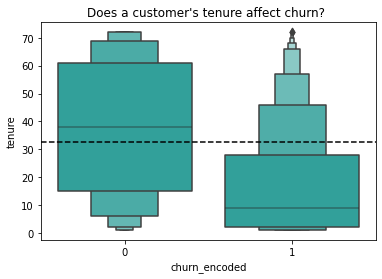

In [9]:
average = train["tenure"].mean()
sns.boxenplot(data=train, x='churn_encoded', y="tenure", color='lightseagreen')
plt.title("Does a customer's tenure affect churn? ")
plt.axhline(average, ls='--', color='black') 
plt.show()

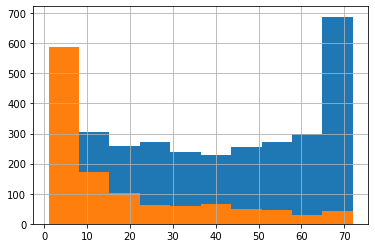

In [10]:
train_no_churn['tenure'].hist()
train_churn['tenure'].hist()
plt.show()

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

$H_0$ = There is no difference in tenure between those who churn and don't churn 

$H_a$ = There is a difference in tenure between those who churn and don't churn 

**Independent:** Yes. Two separate groups churn and no_churn

**Normal distribution:** Yes. Enough observations

**Equal variances:** Check $\Downarrow$

In [15]:
alpha = 0.05

In [11]:
stats.levene(train_churn.tenure, train_no_churn.tenure)

LeveneResult(statistic=279.0983604857994, pvalue=7.303234343977914e-61)

pvalue < 0.5 sooooo they are NOT equal must use equal_var = False

In [22]:
tstat, p = stats.ttest_ind(train_churn.tenure, train_no_churn.tenure, equal_var= False)

In [23]:
if (p < alpha):
    print("we can reject the null hypothesis")
else:
    print('We fail to reject the null hypothesis')

we can reject the null hypothesis


### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

**There is a relationship between tenure and churn.**

## Do higher monthly charges affect churn? :

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

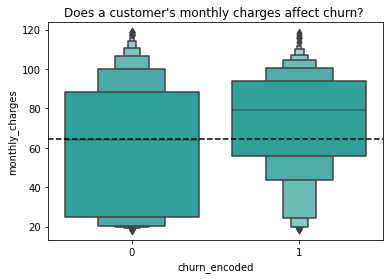

In [30]:
average = train["monthly_charges"].mean()
sns.boxenplot(data=train, x='churn_encoded', y="monthly_charges", color='lightseagreen')
plt.title("Does a customer's monthly charges affect churn? ")
plt.axhline(average, ls='--', color='black') 
plt.show()

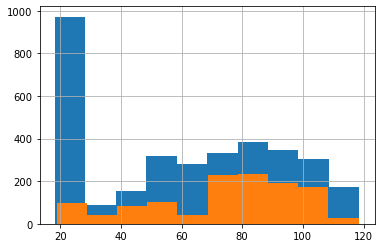

In [17]:
train_no_churn.monthly_charges.hist()
train_churn.monthly_charges.hist()
plt.show()

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

$H_0$ = Monthly charges of those who churn $\leq$ monthly charges of those who don't churn

$H_a$ = Monthly charges of those who churn $>$ monthly charges of those who don't churn

**Independent:** Yes. Two separate groups churn and no_churn

**Normal distribution:** Yes. Enough observations

**Equal variances:** Check $\Downarrow$

In [18]:
alpha = 0.05

In [19]:
stats.levene(train_churn.monthly_charges, train_no_churn.monthly_charges)

LeveneResult(statistic=248.35641580913386, pvalue=1.5798656854889806e-54)

pvalue < 0.5 sooooo they are NOT equal must use equal_var = False

In [20]:
tstat, p = stats.ttest_ind(train_churn.monthly_charges, train_no_churn.monthly_charges, equal_var= False)

In [24]:
if (p/2 < alpha):
    print("we can reject the null hypothesis")
else:
    print('We fail to reject the null hypothesis')

we can reject the null hypothesis


### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

**Those who have higher monthly charges are probably more likely to churn.**

## Does contract type affect churn? :

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

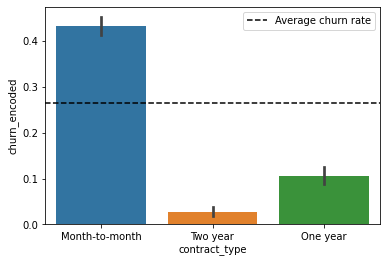

In [26]:
sns.barplot(x="contract_type", y="churn_encoded", data=train)
rate = train["churn_encoded"].mean()
plt.axhline(rate, label = f'Average churn rate', linestyle='--', color='black')
plt.legend()
plt.show()

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

$H_0$ = There is no difference in monthly charges between those who churn and don't churn 

$H_a$ = There is a difference in monthly charges between those who churn and don't churn 

**Independent:** Yes. Two separate groups churn and no_churn

**Normal distribution:** Yes. Enough observations

**Equal variances:** Check $\Downarrow$

In [18]:
alpha = 0.05

In [19]:
stats.levene(train_churn.monthly_charges, train_no_churn.monthly_charges)

LeveneResult(statistic=248.35641580913386, pvalue=1.5798656854889806e-54)

pvalue < 0.5 sooooo they are NOT equal must use equal_var = False

In [20]:
tstat, p = stats.ttest_ind(train_churn.monthly_charges, train_no_churn.monthly_charges, equal_var= False)

In [21]:
if (p < alpha):
    print("we can reject the null hypothesis")
else:
    print('We fail to reject the null hypothesis')

we can reject the null hypothesis


### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

**There is a relationship between monthly charges and churn.**

## Exploration Summary
* After your explore section, before you start modeling, provide a summary of your findings in Explore
* Include a summary of your take-aways
* Include a summary of the features you examined and weather or not you will be going to Modeling with each feature and why
* It is important to note which features will be going into your model so the reader knows what features you are using to model on

## Modeling

### Introduction
* Explain how you will be evaluating your models
* Include the evaluation metric you will be using and why you have chosen it
* Create a baseline and briefly explain how it was calculated 

In [3]:
# If you use code to generate your baseline run the code and generate the output here

Printout should read: <br>
Baseline: "number" "evaluation metric"

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

### Model Type

In [4]:
# Code that runs the best model in that model type goes here 
# (This may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [5]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.